# SEMEP vs MEP

Chun-Yao Yang

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import totalsedimentload as tsl
from matplotlib.patches import Polygon
import matplotlib.ticker as ticker

from read_korean_data import *
from py_sedyield import *
%matplotlib inline

In [2]:
#plt.rc('font', family='Helvetica')
plt.rc("xtick",labelsize="large")
plt.rc("ytick",labelsize="large")
plt.rc("axes", labelsize="large")
plt.rc("legend", framealpha = None)

In [21]:
paths = findExcelFiles()

stations = {}

raw_length = 0
for path in paths:
    i = path.rfind("/")
    j = path.find("_", i)
    k = path.find("_", j+1)
    f = path[j+1:k]

# MEP
    mep = read_sediment_measurement(path)
    raw_length += len(mep)
    mep[['Q', 'C', 'Qt']] = mep[['Q', 'C', 'Qt']].apply(lambda x: pd.to_numeric(x, errors='coerce'))
    stations[f] = {'mep':mep}

#SEMEP   

    df2 = tsl.raw_extract(path)
    #print(df2)
    
    semep = tsl.semep_procedure(df2)
    

    stations[f].update({'semep':semep})
    #Q = semep.Q
    #Qt = semep.Qt

    #q_qt_semep = trainLinear(Q, Qt)
    #df2['site'] = f
    #stations[f].update({'qt_semep':q_qt_semep, 'semep':semep, 'input':df2})
print('number of sediment samples: ', raw_length)

C:\Users\cyyang\Dropbox\work\dissertation\totalsedimentload.py:126: FutureWarning: the 'parse_cols' keyword is deprecated, use 'usecols' instead
  ,names=["Date", "A", "h", "Q", "Temp", "C", "d50", "d65", "dss", "S"])
C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


number of sediment samples:  2084


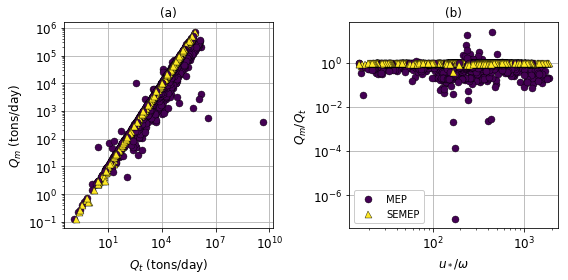

In [5]:
fig, (ax2, ax1) = plt.subplots(1,2,figsize=(8,4))
classic_kwargs = {'ms': 7, 'mec': 'k', 'mew': 0.4}

mep_label = "MEP"
semep_label = "SEMEP"

for site, method in stations.items():
    mep = method['mep']
    semep = method['semep']
    u = semep[['Q', 'u/w']]
    mep = mep.merge(u, on='Q')
    Qm = mep['Q'] * mep['C'] * 0.0864
    
    ax1.plot(mep['u/w'], Qm/mep['Qt'], 'o', color=plt.cm.viridis(0), **classic_kwargs, label=mep_label)
    ax1.plot(semep['u/w'], semep['qm/qt'], '^', color=plt.cm.viridis(1.), **classic_kwargs, label=semep_label)
    mep_label = "_nolegend_"
    semep_label = "_nolegend_"
    
    
    ax2.plot(mep['Qt'], Qm, 'o', color=plt.cm.viridis(0), **classic_kwargs)
    ax2.plot(semep['Qt'], semep['Qm'],'^', color=plt.cm.viridis(1.), **classic_kwargs)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.grid(which='major')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.grid(which='major')
ax1.set_xlabel(r'$u_*/\omega$')
ax1.set_ylabel('$Q_m/Q_t$')
ax1.legend(loc=3, framealpha=1)
ax2.set_xlabel('$Q_t$ (tons/day)')
ax2.set_ylabel('$Q_m$ (tons/day)')
ax1.set_title("(b)")
ax2.set_title("(a)")
fig.tight_layout()

#plt.savefig('./figures/mep_vs_semep/mep_vs_semep_all.pdf', format='pdf', dpi=300)

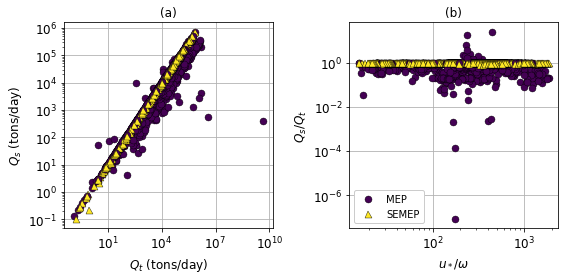

In [6]:
fig, (ax2, ax1) = plt.subplots(1,2,figsize=(8,4))
classic_kwargs = {'ms': 7, 'mec': 'k', 'mew': 0.4}

mep_label = "MEP"
semep_label = "SEMEP"

for site, method in stations.items():
    mep = method['mep']
    semep = method['semep']
    u = semep[['Q', 'u/w']]
    mep = mep.merge(u, on='Q')
    ax1.plot(mep['u/w'], mep['Qs']/mep['Qt'], 'o', color=plt.cm.viridis(0), **classic_kwargs, label=mep_label)
    ax1.plot(semep['u/w'], semep['qs/qt'], '^', color=plt.cm.viridis(1.), **classic_kwargs, label=semep_label)
    mep_label = "_nolegend_"
    semep_label = "_nolegend_"

    ax2.plot(mep['Qt'],mep['Qs'], 'o', color=plt.cm.viridis(0), **classic_kwargs)
    ax2.plot(semep['Qt'], semep['Qt']*semep['qs/qt'],'^', color=plt.cm.viridis(1.), **classic_kwargs)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.grid(which='major')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.grid(which='major')
ax1.set_xlabel(r'$u_*/\omega$')
ax1.set_ylabel('$Q_s/Q_t$')
ax1.legend(loc=3)
ax2.set_xlabel('$Q_t$ (tons/day)')
ax2.set_ylabel('$Q_s$ (tons/day)')
ax1.set_title("(b)")
ax2.set_title("(a)")
fig.tight_layout()

In [8]:
for path in paths:
    i = path.rfind("/")
    j = path.find("_", i)
    k = path.find("_", j+1)
    f = path[j+1:k]

    dailyQ = read_dischargeTimeSeries(path)
    fdc = flowDuration(dailyQ)
    Qmean = fdc.Q.mean()
    stations[f].update({'Qmean':Qmean})

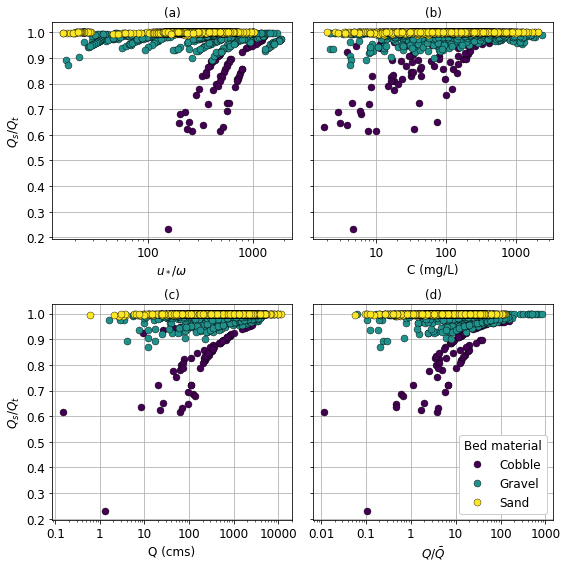

In [9]:
C = []
for site in stations.keys():
    df = stations[site]['semep']
    df['site'] = site
    C.append(df)

C = pd.concat(C).reset_index(drop=True)
C = C[(2 * C['d50'] < C['h'])]

sand = C.loc[C['d50'] <= 2/1000].index
cobble = C.loc[C['d50'] > 64/1000].index
gravel = C.loc[(C['d50'] > 2/1000) & (C['d50'] <= 64/1000)].index

fig, ((ax2, ax3), (ax, ax4)) = plt.subplots(2,2, sharey=True, figsize=(8,8))


color = iter(plt.cm.viridis(np.linspace(0,1,3)))

for material, text in zip([cobble, gravel, sand], ["Cobble", "Gravel", "Sand"]):
    c = next(color)
    ax2.plot(C.loc[material, 'u/w'], C.loc[material, ['qs/qt']], 'o', color= c, **classic_kwargs, label=text)
    ax.plot(C.loc[material, 'Q'], C.loc[material, ['qs/qt']], 'o', color=c, **classic_kwargs, label=text)
    ax3.plot(C.loc[material, 'C'], C.loc[material, ['qs/qt']], 'o', color=c, **classic_kwargs, label=text)
    ax4.plot(C.loc[material, 'Q']/C.loc[material, 'site'].apply(lambda x: stations[x]['Qmean']),
         C.loc[material, ['qs/qt']], 'o', color=c, **classic_kwargs, label=text)


ax2.set(xlabel=r'$u_*/\omega$', ylabel=r'$Q_s/Q_t$', title="(a)")
ax.set(xlabel=r'Q (cms)', ylabel=r'$Q_s/Q_t$', title="(c)")
ax3.set(xlabel=r'C (mg/L)', title="(b)")
ax4.set(xlabel=r"$Q/\bar{Q}$", title="(d)")


for axes in [ax, ax2, ax3, ax4]:
    axes.grid()
    axes.set_xscale('log')
    axes.xaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))



## legend
ax4.legend(loc=4, fontsize='large', framealpha=1)
ax4.legend(loc=4, fontsize='large', framealpha=1, title='Bed material')
ax4.get_legend().get_title().set_fontsize('large')


fig.tight_layout()
#fig.savefig('./figures/mep_vs_semep/suspended_fraction.pdf', format='pdf', dpi=300)

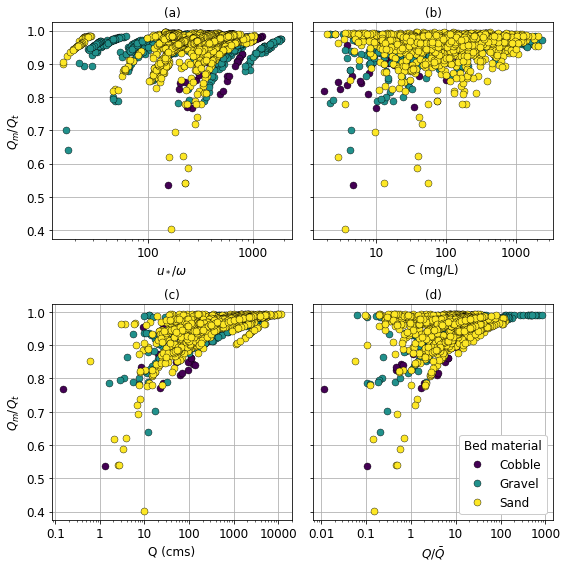

In [10]:
fig, ((ax2, ax3), (ax, ax4)) = plt.subplots(2,2, sharey=True, figsize=(8,8))


color = iter(plt.cm.viridis(np.linspace(0,1,3)))

for material, text in zip([cobble, gravel, sand], ["Cobble", "Gravel", "Sand"]):
    c = next(color)
    ax2.plot(C.loc[material, 'u/w'], C.loc[material, ['qm/qt']], 'o', color= c, **classic_kwargs, label=text)
    ax.plot(C.loc[material, 'Q'], C.loc[material, ['qm/qt']], 'o', color=c, **classic_kwargs, label=text)
    ax3.plot(C.loc[material, 'C'], C.loc[material, ['qm/qt']], 'o', color=c, **classic_kwargs, label=text)
    ax4.plot(C.loc[material, 'Q']/C.loc[material, 'site'].apply(lambda x: stations[x]['Qmean']),
         C.loc[material, ['qm/qt']], 'o', color=c, **classic_kwargs, label=text)


ax2.set(xlabel=r'$u_*/\omega$', ylabel=r'$Q_m/Q_t$', title="(a)")
ax.set(xlabel=r'Q (cms)', ylabel=r'$Q_m/Q_t$', title="(c)")
ax3.set(xlabel=r'C (mg/L)', title="(b)")
ax4.set(xlabel=r"$Q/\bar{Q}$", title="(d)")


for axes in [ax, ax2, ax3, ax4]:
    axes.grid()
    axes.set_xscale('log')
    axes.xaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))



## legend
ax4.legend(loc=4, fontsize='large', framealpha=1, title='Bed material')
ax4.get_legend().get_title().set_fontsize('large')

fig.tight_layout()
#fig.savefig('./figures/mep_vs_semep/measured_fraction.pdf', format='pdf', dpi=300)

In [11]:
def qm_func(e, a, ro):
    vJ1A = np.vectorize(tsl.J1A)
    vJ2A = np.vectorize(tsl.J2A)
    J1m = vJ1A(ro, a)
    J2m = vJ2A(ro, a)
    return 0.216 * (e**(ro-1)/(1-e)**ro)*(np.log(60/e) * J1m + J2m)

def qt_func(e, a, ro):
    vJ1A = np.vectorize(tsl.J1A)
    vJ2A = np.vectorize(tsl.J2A)
    J1 = vJ1A(ro, e)
    J2 = vJ2A(ro, e)
    return 1 + 0.216 * (e**(ro-1)/(1-e)**ro)*(np.log(60/e) * J1 + J2)  

def qs_func(e, a, ro):
    vJ1A = np.vectorize(tsl.J1A)
    vJ2A = np.vectorize(tsl.J2A)
    J1 = vJ1A(ro, e)
    J2 = vJ2A(ro, e)
    return 0.216 * (e**(ro-1)/(1-e)**ro)*(np.log(60/e) * J1 + J2) 



In [12]:
def Ro_to_u(ro):
    return (1./(ro))/0.4

def u_to_Ro(u):
    return (1/u)/0.4

In [13]:
ds1 = np.linspace(0.002, 0.15, 20)
ds2 = np.linspace(0.0005, 0.002, 20)

h = np.linspace(4, 1000, 1000)

A = tsl.E(0.1, h)

Ro = np.arange(0, 2.4,0.3)

E = 2/h
#E = np.linspace((2 * C['d50']/C['h']).min(), 0.8, 1000)

In [14]:
E = np.linspace((2 * C['d50']/C['h']).min(), 0.8, 1000)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


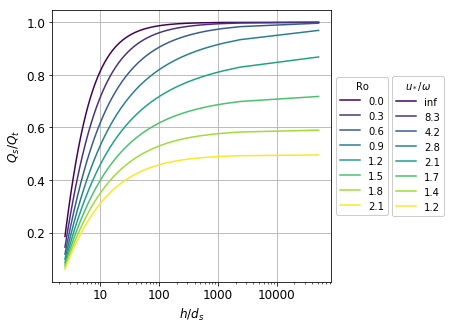

In [16]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

color = iter(plt.cm.viridis(np.linspace(0,1,len(Ro))))

for ro in Ro:
    c = next(color)
    ax.plot(2/E, qs_func(E, A, ro)/qt_func(E, A, ro), '-', color=c, label=round(ro,1))
ax.set_xscale('log')
#plt.yscale('log')
ax.set_xlabel('$h/d_s$')
ax.set_ylabel(r'$Q_s/Q_t$')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))
ax.grid()

lines = ax.get_lines()
leg1 = ax.legend(title='Ro', loc='center left', bbox_to_anchor=(1, 0.5))
leg2 = ax.legend(lines, np.round(2.5/Ro, 1), title=r'$u_*/\omega$', loc='center left', bbox_to_anchor=(1.2, 0.5))
                 
ax.add_artist(leg1)
#fig.savefig('./figures/mep_vs_semep/qs_qt.pdf', bbox_inches="tight", dpi=300)

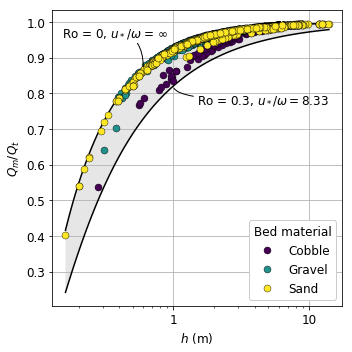

In [17]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

h = np.logspace(np.log10(0.16), np.log10(14), 100)
ds = 2/1000
Ro = [0, 0.3]

for ro in Ro:
    ax.plot(h, qm_func(2*ds/h, 0.1/h, ro)/qt_func(2*ds/h, 0.1/h, ro) , color='k')

ax.fill_between(h, qm_func(2*ds/h, 0.1/h, 0.3)/qt_func(2*ds/h, 0.1/h, 0.3), 
                qm_func(2*ds/h, 0.1/h, 0)/qt_func(2*ds/h, 0.1/h, 0), facecolor='0.9')    

color = iter(plt.cm.viridis(np.linspace(0,1,3)))

for material, text in zip([cobble, gravel, sand], ["Cobble", "Gravel", "Sand"]):
    c = next(color)
    ax.plot(C.loc[material,'h'],  C.loc[material,'qm/qt'], 
            'o', color=c, **classic_kwargs, label=text)

ax.set(xlabel=r'$h$ (m)', xscale='log', ylabel=r'$Q_m/Q_t$')


ax.grid()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))
ax.annotate(r"Ro = 0, $u_*/\omega$ = $\infty$", (0.6, 0.87), (0.15,0.95), ha='left', va='bottom',
                                arrowprops=dict(arrowstyle='-',
                                connectionstyle="angle3,angleA=0,angleB=90",
                                ), fontsize='large')

ax.annotate(r"Ro = 0.3, $u_*/\omega=8.33$", (1, 0.82), (1.5, 0.8), va='top', 
                arrowprops=dict(arrowstyle='-',
                connectionstyle="angle3,angleA=0,angleB=90"),
                fontsize='large')           

## legend
ax.legend(loc=4, fontsize='large', framealpha=1, title='Bed material')
ax.get_legend().get_title().set_fontsize('large')
fig.tight_layout()
#fig.savefig('./figures/mep_vs_semep/qm_qt_korea.pdf', dpi=300)


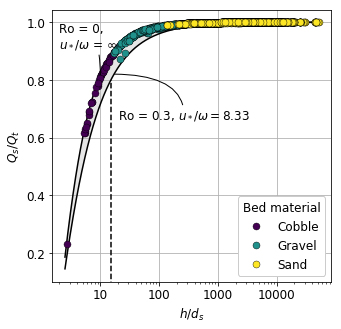

In [18]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
E = np.linspace((2 * C['d50']/C['h']).min(), 0.8, 1000)
Ro = [0, 0.3]
#color = iter(plt.cm.viridis(np.linspace(0,1,len(Ro))))

for ro in Ro:
#    c = next(color)
    ax.plot(2/E, qs_func(E, A, ro)/qt_func(E, A, ro), '-', color='k')
    

ax.fill_between(2/E, qs_func(E, A, 0.3)/qt_func(E, A, 0.3), 
                qs_func(E, A, 0)/qt_func(E, A, 0), facecolor='0.9')
    

ax.set_xscale('log')
#plt.yscale('log')
ax.set_xlabel('$h/d_s$')
ax.set_ylabel(r'$Q_s/Q_t$')
ax.grid()
#plt.legend(title='$Z$', loc='center left', bbox_to_anchor=(1, 0.5))


color = iter(plt.cm.viridis(np.linspace(0,1,3)))

for material, text in zip([cobble, gravel, sand], ["Cobble", "Gravel", "Sand"]):
    c = next(color)
    ax.plot(C.loc[material,'h']/C.loc[material,'d50'],  C.loc[material,'qs/qt'], 
            'o', color=c, **classic_kwargs, label=text)

# legend    
ax.legend(loc=4, fontsize='large', framealpha=1, title='Bed material')
ax.get_legend().get_title().set_fontsize('large')

# annotation
ax.annotate("Ro = 0, \n$u_*/\omega$ = $\infty$", (10, 0.81), (2,0.90), ha='left', va='bottom',
                                arrowprops=dict(arrowstyle='-',
                                connectionstyle="angle3,angleA=0,angleB=90",
                                ), fontsize='large')

ax.annotate(r"Ro = 0.3, $u_*/\omega=8.33$", (16, 0.82), (20, 0.7), va='top', ha='left', 
                arrowprops=dict(arrowstyle='-',
                connectionstyle="angle3,angleA=90,angleB=0"),
                fontsize='large') 
ax.set_ylim(ymin=0.1)
ax.plot([15.12, 15.12], [0, 0.8], 'k--')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))
#fig.savefig('./figures/mep_vs_semep/qs_qt_korea.pdf', dpi=300)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide


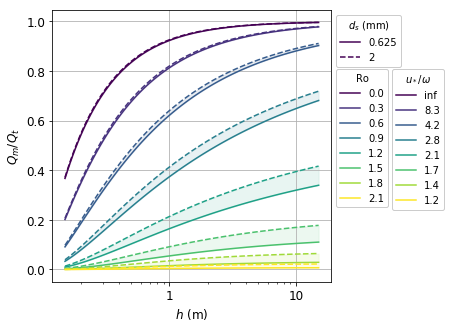

In [19]:
from matplotlib import pyplot

fig, ax = plt.subplots(1,1, figsize=(5,5))


h = np.logspace(np.log10(0.15), np.log10(15), 100)
Ds = [0.625/1000, 2/1000]
Ro = np.arange(0, 2.1,0.3)

color = iter(plt.cm.viridis(np.linspace(0,1,len(Ro))))
linestyle = ['-', '--']


for ro in Ro:
    c = next(color)
    for ds, ls in zip(Ds, linestyle):       
        ax.plot(h, qm_func(2*ds/h, 0.1/h, ro)/qt_func(2*ds/h, 0.1/h, ro), ls=ls, color=c)
    ax.fill_between(h, qm_func(2*(0.625/1000)/h, 0.1/h, ro)/qt_func(2*(0.625/1000)/h, 0.1/h, ro), 
                    qm_func(2*(2/1000)/h, 0.1/h, ro)/qt_func(2*(2/1000)/h, 0.1/h, ro), color=c, alpha=0.1)
        
lines = ax.get_lines()      
ax.set_xscale('log')
ax.set_xlabel('$h$ (m)')
ax.set_ylabel(r'$Q_m/Q_t$')
ax.grid()

legend1 = pyplot.legend([lines[i] for i in [0,1]], ["0.625", "2"], title='$d_s$ (mm)', loc="upper left",
                        bbox_to_anchor=(1, 1))
legend2 = pyplot.legend([lines[i] for i in [0,2,4,6,8,10,12,14]], np.around(Ro, decimals=1), title='Ro', 
                        loc="upper left", bbox_to_anchor=(1, 0.8))
legend3 = pyplot.legend([lines[i] for i in [0,2,4,6,8,10,12,14]], np.around(2.5/Ro, decimals=1), title=r'$u_*/\omega$', 
                        loc="upper left", bbox_to_anchor=(1.2, 0.8))

fig.artists.append(legend1)
fig.artists.append(legend2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))
#fig.subplots_adjust(right=1)
#fig.savefig('./figures/mep_vs_semep/qm_qt.pdf', bbox_inches="tight")